second draft, gonna cut out the mass estimate and:

ignore everything without a mass
if no uncertainty on mass, ignore, 
maybe with radius - ignore too
can calc orbsmax with stellar mass and period
add in transit duration

In [ ]:
#initial filtering code
import pandas as pd
import numpy as np
df = pd.read_csv('Data/archive_data_15.01.26.csv', comment='#')

# choose columns we want to keep 
useful_columns_only = df[['pl_name', 'pl_orbper', 'pl_orbsmax', 'pl_masse', 'pl_rade', 'pl_radelim', 'pl_radeerr1', 'pl_radeerr2',
                'pl_trandep', 'pl_trandur', 'pl_masselim', 'pl_masseerr2', 'pl_masseerr1', 'pl_orbeccen', 'pl_orbincl', 'st_rad', 
                'st_mass', 'st_teff', 'pl_ratror','sy_jmag', 'discoverymethod', 'default_flag']]

# filter for default parameter rows only
default_planets = useful_columns_only[useful_columns_only['default_flag'] == 1]

#remove planets with no mass or 0 uncertainty on mass or lim flag on mass
default_planets = default_planets[
    (default_planets['pl_masse'].notna()) &
    (default_planets['pl_masseerr1'] != 0) &
    (default_planets['pl_masseerr2'] != 0) &
    (default_planets['pl_masselim'] == 0)
]




# set size limits for filtering
radius_lower = 1.5 # earth radii
radius_upper = 4 

# filter for planets in size limits
filtered_sizes = default_planets[
    (default_planets['pl_rade'] >= radius_lower) &
    (default_planets['pl_rade'] <= radius_upper)
]

# checks
print('initial downloaded table dimensions:', df.shape)
print('column filtered table dimensions:', useful_columns_only.shape)
print('default planets table dimensions:', default_planets.shape)
print('size filtered table dimensions:', filtered_sizes.shape)
filtered_sizes[['pl_name','pl_masse', 'pl_masseerr1', 'pl_masseerr2', 'pl_masselim']].head()


initial downloaded table dimensions: (39235, 111)
column filtered table dimensions: (39235, 22)
default planets table dimensions: (1852, 22)
size filtered table dimensions: (372, 22)


,pl_name,pl_masse,pl_masseerr1,pl_masseerr2,pl_masselim
125,55 Cnc e,7.990000,0.320000,-0.330000,0.0
205,BD+20 594 b,22.248100,9.534900,-9.534900,0.0
376,CoRoT-7 b,4.076605,1.019818,-1.019818,0.0
417,EPIC 201595106 b,7.670000,0.750000,-0.750000,0.0
503,EPIC 220674823 b,7.800000,0.710000,-0.700000,0.0


In [106]:
# filtered_sizes.to_csv('filtered_exoplanets.csv', index=False)   

### Calculating T_eq
might as well calculate the TSM for each one (or filter those we can't calc for? not for now.)
- needs equilibrium temperature first
- also remember to check how much 0 vs 0.3 albedo changes things

$T_{eq} = T_{star} * \sqrt{\frac{R_{star}}{2a}} * (1 - A)^{\frac{1}{4}}$

in code form is 

T_eq = T_star * (R_star / 2a)**0.5 * (1 - A))**0.25

In [107]:
# function to calculate equilibrium temperature

def calc_Teq(T_star, R_star, a_AU, A=0):
    """Calculates eq temp (assuming full heat redistribution)
    T_star : stellar temp in Kelvin
    R_star : stellar R in R_sun
    a_AU   : orbital semi-major axis [AU]
    A      : bond albedo (default 0)
    """
    a_Rsun = a_AU * 215.032  # need matching units
    return T_star * (R_star / (2*a_Rsun))**0.5 * (1 - A)**0.25

In [108]:
fs_with_Teq = filtered_sizes.copy()
fs_with_Teq['pl_Teq'] = calc_Teq(
    fs_with_Teq['st_teff'],
    fs_with_Teq['st_rad'],
    fs_with_Teq['pl_orbsmax'],
    A=0.3
)
fs_with_Teq[['pl_name','st_teff','st_rad','pl_orbsmax','sy_jmag','pl_Teq']].head()

,pl_name,st_teff,st_rad,pl_orbsmax,sy_jmag,pl_Teq
125,55 Cnc e,5172.0,0.943,0.01544,4.768000,1782.783802
176,AU Mic b,3678.0,0.744,0.06490,5.436000,549.267382
187,AU Mic c,3678.0,0.744,0.11080,5.436000,420.374417
205,BD+20 594 b,5766.0,1.080,NaN,9.770001,NaN
336,CoRoT-24 b,4950.0,0.860,0.05600,13.595000,855.595272


##### Check how many T_eq not NaN
Lovely. how many of these can we actually get Eq temp for?

In [109]:
print('with all rows:',fs_with_Teq.shape)
fs_with_Teq.dropna(subset=['pl_Teq']).shape
print('with only rows with value for Teq:',fs_with_Teq.dropna(subset=['pl_Teq']).shape)

with all rows: (2467, 17)
with only rows with value for Teq: (1094, 17)


Wayyyyy less. Okay, is this standard?
Also, should we be dismissing the rows that don't have the essentials in anyway? What are the essentials?

Will need to hear from team 1 what they need. can further filter easily, by changing the initial list in the first code block. Nothing done here is permanent, can just run again with whatever initial is needed. In this case dismissing rows for now is unneccesary, and will do the TSM now.

### Calculating TSM

$$\text{TSM} = \text{SF} \times \frac{R_p^3 \, T_\mathrm{eq}}{M_p \, R_*^2} \times 10^{-m_J/5}$$


TSM includes **scale factor** which 'is a normalization constant and also is responsible for unit conversion. Determined separately based on planet radius bin.'

Paper uses scale factor of 1.26 for 1.5-2.75 R_earth planets, and 1.28 for 2.75-4.0 R_earth planets.
Using 1.27 for now.

In [110]:
def calc_TSM(R_p, M_p, T_eq, R_star, mJ=9.5, scale_factor=1.27):
    """Calculates Transmission Spectroscopy Metric (TSM) from Kempton+2018
    R_p : planet radius (R_earth)
    M_p : planet mass (M_earth)
    T_eq: planet eq temp in K
    R_star: units of R_sun
    mJ  : J-band magnitude of host star 
    scale_factor: depends on planet size regime (See Kempton+2018 for some values)
    """
    TSM = (scale_factor * (R_p**3 * T_eq) / (M_p * R_star**2) * 10**(-mJ/5))
    return TSM


In [111]:
# maybe cos of scale factor, not best to compute whole table at once? can come back to later. 

fs_with_TSM = fs_with_Teq.copy()
fs_with_TSM['pl_tsm'] = calc_TSM(
    fs_with_TSM['pl_rade'],
    fs_with_TSM['pl_masse'],
    fs_with_TSM['pl_Teq'],
    fs_with_TSM['st_rad'],
    fs_with_TSM['sy_jmag'],  # 2MASS J-mag
    scale_factor=1.27  # placeholder value; adjust based on planet size regime
)
fs_with_TSM[['pl_name','pl_rade','pl_masse','pl_Teq','st_rad','sy_jmag','pl_tsm']].head()
#fs_with_TSM.head(20)

,pl_name,pl_rade,pl_masse,pl_Teq,st_rad,sy_jmag,pl_tsm
125,55 Cnc e,1.875000,7.9900,1782.783802,0.943,4.768000,233.741621
176,AU Mic b,3.956770,NaN,549.267382,0.744,5.436000,NaN
187,AU Mic c,2.522021,NaN,420.374417,0.744,5.436000,NaN
205,BD+20 594 b,2.578070,22.2481,NaN,1.080,9.770001,NaN
336,CoRoT-24 b,3.700000,5.7000,855.595272,0.860,13.595000,24.934778


##### Check how many TSM not NaN
Nice! Now how many of these actually have TSM values (hopefully not much less than those with T_eq)?

In [112]:
print('with all rows:',fs_with_TSM.shape)
fs_with_TSM.dropna(subset=['pl_tsm']).shape
print('with only rows with value for Teq:',fs_with_Teq.dropna(subset=['pl_Teq']).shape)
print('with only rows with value for TSM:',fs_with_TSM.dropna(subset=['pl_tsm']).shape)

with all rows: (2467, 18)
with only rows with value for Teq: (1094, 17)
with only rows with value for TSM: (306, 18)


##### Initial TSM histogram
Well that narrows it down a bit. Archie notes - paper describes 300 high quality targets over large radius (inc > R_nep), and we have 300 of any quality. Maybe histogram the TSM?


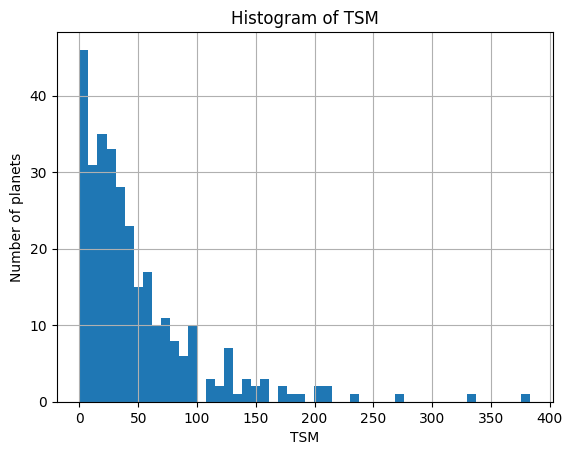

In [ ]:
import matplotlib.pyplot as plt

fs_with_TSM['pl_tsm'].hist(bins=50) 
plt.xlabel('TSM')
plt.ylabel('Number of planets')
plt.title('Histogram of TSM')
plt.show()
# checked and this ignores NaNs automatically

Seems to be in a normal range, although paper gave ranges that look a bit out.

In [ ]:
# this is for comparison with the 2018 paper quartiles which seem to be a lot higher (and they split our range into 2 categories!)
# Sort all planets by TSM descending
top_100 = fs_with_TSM.sort_values(by='pl_tsm', ascending=False).head(100)

# Compute quartiles of these top 100 planets
quartiles_top100 = top_100['pl_tsm'].quantile([0, 0.25, 0.50, 0.75])
print(quartiles_top100) 

0.00     49.875200
0.25     62.578652
0.50     83.464029
0.75    123.828890
Name: pl_tsm, dtype: float64


In [116]:
print('with all rows:',fs_with_TSM.shape)
fs_with_TSM.dropna(subset=['pl_tsm']).shape
print('with only rows with value for Teq:',fs_with_Teq.dropna(subset=['pl_Teq']).shape)
print('with only rows with value for TSM:',fs_with_TSM.dropna(subset=['pl_tsm']).shape)

with all rows: (2467, 18)
with only rows with value for Teq: (1094, 17)
with only rows with value for TSM: (306, 18)


##### What data is missing?

In [117]:
# columns needed for TSM + Teq
required_cols = ['pl_rade', 'pl_masse', 'pl_Teq', 'st_rad', 'sy_jmag', 'st_teff', 'pl_orbsmax']

missing_counts = fs_with_TSM[required_cols].isna().sum()
print(missing_counts)



pl_rade          0
pl_masse      2030
pl_Teq        1373
st_rad          12
sy_jmag          1
st_teff         54
pl_orbsmax    1360
dtype: int64
